# Road Lane Detection with U-Net++ (TensorFlow + Albumentations)

This notebook demonstrates a complete pipeline for **road lane segmentation** using **U-Net++**, leveraging **TensorFlow**, **mixed precision training**, and **Albumentations** for robust data augmentation. The dataset is derived from a subset of [**CULane**](https://xingangpan.github.io/projects/CULane.html), preprocessed to suit a semantic segmentation task.

## Objective

To build an accurate and efficient model that can **segment lane markings** under varying real-world driving conditions such as shadows, motion blur, and brightness variations.

## Pipeline Overview

**Step 1 – Data Loading & Visualization**  
Organize the dataset into train/val/test splits and preview random image–mask pairs.

**Step 2 – Preprocessing & Augmentation**  
Resize inputs, binarize masks, and apply realistic data augmentation using Albumentations.

**Step 3 – Model Architecture**  
Build the U-Net++ architecture with skip connections and deep supervision.

**Step 4 – Training Setup**  
Use Adam optimizer, mixed precision training, custom loss (BCE + Dice), and callbacks.

**Step 5 – Training**  
Train the model with early stopping, checkpointing, and learning rate scheduling.

**Step 6 – Evaluation & Visualization**  
Visualize predictions, evaluate metrics, and compare outputs on unseen test samples.


### Data Loading & Exploration

In [1]:
# Imports and Environment Setup
import os
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt

# Set environment variables for deterministic and optimized behavior
os.environ["TF_DETERMINISTIC_OPS"] = "1"  # Enforce deterministic operations (important for reproducibility)
os.environ["TF_CUDNN_USE_AUTOTUNE"] = "0"  # Disable cuDNN auto-tuning for deterministic results
os.environ['XLA_FLAGS'] = '--xla_disable_hlo_passes=slow-operation-alarm'  # Suppress long-running operation warnings

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras import mixed_precision
from tensorflow.keras.models import load_model

# Enable mixed precision
mixed_precision.set_global_policy('mixed_float16')

# Augmentation and Utilities
import albumentations as A
from tqdm import tqdm

# Suppress TensorFlow warnings and logs
import logging
tf.get_logger().setLevel(logging.ERROR)

2025-07-01 03:00:19.518186: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751338819.731968      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751338819.797145      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
# Define dataset paths
data_dir = '/kaggle/input/road-lane-detection2/processed'
train_img_dir = os.path.join(data_dir, 'train/images')
train_mask_dir = os.path.join(data_dir, 'train/masks')

print(f"Number of training images: {len(os.listdir(train_img_dir))}")
print(f"Number of training masks: {len(os.listdir(train_mask_dir))}")

Number of training images: 12763
Number of training masks: 12763


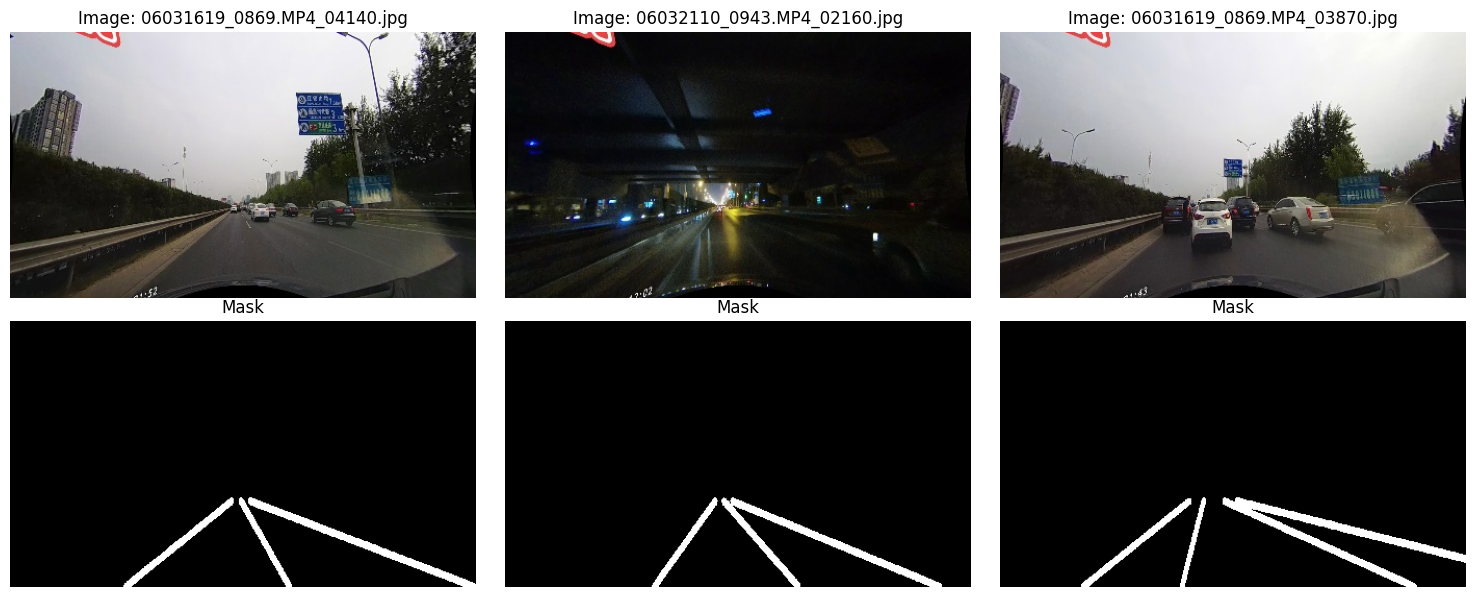

In [3]:
# List all image filenames from all subfolders
all_files = sorted(os.listdir(train_img_dir))

# Pick 3 random, non-consecutive images for diversity
sample_files = random.sample(all_files, 3)

plt.figure(figsize=(15, 6))
for i, fname in enumerate(sample_files):
    img_path = os.path.join(train_img_dir, fname)
    mask_path = os.path.join(train_mask_dir, fname.replace('.jpg', '.png'))

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(f"Image: {fname}")
    plt.axis('off')

    plt.subplot(2, 3, i + 4)
    plt.imshow(mask, cmap='gray')
    plt.title("Mask")
    plt.axis('off')

plt.tight_layout()
plt.show()

### Preprocessing & Augmentation: tf.data + Albumentations

#### We use a `tf.data.Dataset` pipeline with augmentation using Albumentations to simulate lighting changes, shadows, and motion blur.

In [4]:
# Albumentations Augmentation
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.RandomShadow(p=0.3),
    A.MotionBlur(blur_limit=5, p=0.2),
    A.RandomGamma(p=0.3),
])

# Albumentations wrapper for use inside tf.data pipeline
def albumentations_wrapper(image, mask):
    augmented = transform(image=image, mask=mask)
    return augmented['image'].astype(np.float32), augmented['mask'].astype(np.float32)
    
# tf.data-compatible function to apply albumentations
def tf_augment(img, mask):
    [img, mask] = tf.numpy_function(albumentations_wrapper, [img, mask], [tf.float32, tf.float32])
    img.set_shape([256, 448, 3])
    mask.set_shape([256, 448, 1])
    return img, mask

In [5]:
# Decode and normalize a pair of image and mask files
def _decode_image_mask(img_path, mask_path, img_size):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, img_size)
    img = tf.cast(img, tf.float32) / 255.0

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, img_size)
    mask = tf.cast(mask > 127, tf.float32)
    return img, mask

# Build a tf.data.Dataset from image and mask directories
def build_dataset(img_dir, mask_dir, batch_size=8, shuffle=True, augment=True, img_size=(256, 448)):
    img_paths = sorted([os.path.join(img_dir, f) for f in os.listdir(img_dir)])
    mask_paths = sorted([os.path.join(mask_dir, f.replace('.jpg', '.png')) for f in os.listdir(img_dir)])

    dataset = tf.data.Dataset.from_tensor_slices((img_paths, mask_paths))

    def _load(img_path, mask_path):
        img, mask = _decode_image_mask(img_path, mask_path, img_size)
        if augment:
            img, mask = tf_augment(img, mask)
        return img, mask

    dataset = dataset.map(_load, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

In [6]:
# Custom Loss Functions
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    """Computes the Dice Coefficient between the ground truth and prediction."""
    y_true_f = K.flatten(tf.cast(y_true, tf.float32))
    y_pred_f = K.flatten(tf.cast(y_pred, tf.float32))
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    """Returns 1 - Dice Coefficient as a loss."""
    return 1 - dice_coefficient(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    """Combines Binary Crossentropy and Dice loss for better gradient flow."""
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    d_loss = dice_loss(y_true, y_pred)
    return bce + d_loss

## Training with U-Net++

In [7]:
# Configuration Constants
IMG_HEIGHT, IMG_WIDTH = 256, 448 # Input image dimensions
BATCH_SIZE = 4
EPOCHS = 20

DATA_PATH = '/kaggle/input/road-lane-detection2/processed'
TRAIN_PATH = os.path.join(DATA_PATH, 'train')
VAL_PATH = os.path.join(DATA_PATH, 'val')
MODEL_PATH = '/kaggle/working/unetpp_best.keras'

In [8]:
# Convolutional Block
def conv_block(x, filters):
    """Applies two sets of Conv2D -> BatchNorm -> ReLU layers."""
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

# U-Net++ Model Architecture
def build_unet_plus_plus(input_shape=(256, 448, 3), num_classes=1):
    """Constructs the U-Net++ architecture with nested skip connections."""
    inputs = layers.Input(shape=input_shape)
    filters = [16, 32, 64, 128, 256]  # Filter sizes for each level

    # Encoder Path
    x00 = conv_block(inputs, filters[0])
    p0 = layers.MaxPooling2D()(x00)
    x10 = conv_block(p0, filters[1])
    p1 = layers.MaxPooling2D()(x10)
    x20 = conv_block(p1, filters[2])
    p2 = layers.MaxPooling2D()(x20)
    x30 = conv_block(p2, filters[3])
    p3 = layers.MaxPooling2D()(x30)
    x40 = conv_block(p3, filters[4])

    # Decoder Path with Nested Skip Connections (UNet++)
    x01 = conv_block(layers.Concatenate()([x00, layers.UpSampling2D()(x10)]), filters[0])
    x11 = conv_block(layers.Concatenate()([x10, layers.UpSampling2D()(x20)]), filters[1])
    x21 = conv_block(layers.Concatenate()([x20, layers.UpSampling2D()(x30)]), filters[2])
    x31 = conv_block(layers.Concatenate()([x30, layers.UpSampling2D()(x40)]), filters[3])
    x02 = conv_block(layers.Concatenate()([x00, x01, layers.UpSampling2D()(x11)]), filters[0])
    x12 = conv_block(layers.Concatenate()([x10, x11, layers.UpSampling2D()(x21)]), filters[1])
    x22 = conv_block(layers.Concatenate()([x20, x21, layers.UpSampling2D()(x31)]), filters[2])
    x03 = conv_block(layers.Concatenate()([x00, x01, x02, layers.UpSampling2D()(x12)]), filters[0])
    x13 = conv_block(layers.Concatenate()([x10, x11, x12, layers.UpSampling2D()(x22)]), filters[1])
    x04 = conv_block(layers.Concatenate()([x00, x01, x02, x03, layers.UpSampling2D()(x13)]), filters[0])

    # Output Layer
    output = layers.Conv2D(num_classes, (1, 1), activation='sigmoid', dtype='float32')(x04)
    return models.Model(inputs, output)

In [9]:
# Set seed to satisfy determinism constraints
tf.random.set_seed(42)

# Load data
train_ds = build_dataset(os.path.join(TRAIN_PATH, 'images'), os.path.join(TRAIN_PATH, 'masks'), augment=True)
val_ds = build_dataset(os.path.join(VAL_PATH, 'images'), os.path.join(VAL_PATH, 'masks'), augment=False)

opt = tf.keras.optimizers.Adam(1e-4)
opt = mixed_precision.LossScaleOptimizer(opt)

# Compile model
model = build_unet_plus_plus()
model.compile(optimizer=opt, loss=bce_dice_loss,
              metrics=['accuracy', dice_coefficient])

# Callbacks
callbacks = [
    ModelCheckpoint(MODEL_PATH, save_best_only=True, monitor='val_loss', verbose=1),
    EarlyStopping(patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
]

# Model summary
model.summary()

I0000 00:00:1751338895.717034      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751338895.717795      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 448, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast (Cast)               │ (None, 256, 448, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 448, 16)   │            448 │ cast[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256, 448, 16)   │             64 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 256, 448, 16)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 448, 16)   │          2,320 │ re_lu[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 256, 448, 16)   │             64 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 256, 448, 16)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 224, 16)   │              0 │ re_lu_1[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 224, 32)   │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 128, 224, 32)   │            128 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 128, 224, 32)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 224, 32)   │          9,248 │ re_lu_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 128, 224, 32)   │            128 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_3 (ReLU)            │ (None, 128, 224, 32)   │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 112, 32)    │              0 │ re_lu_3[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)    

 Total params: 2,297,441 (8.76 MB)

 Trainable params: 2,293,793 (8.75 MB)

 Non-trainable params: 3,648 (14.25 KB)

In [10]:
# Resume logic
if os.path.exists(MODEL_PATH):
    print(" Found existing checkpoint. Resuming from saved model.")
    model = load_model(MODEL_PATH, custom_objects={
        'dice_coefficient': dice_coefficient,
        'bce_dice_loss': bce_dice_loss
    })
else:
    print(" No checkpoint found. Building and compiling model from scratch.")
    model = build_unet_plus_plus(input_shape=(256, 448, 3))
    opt = tf.keras.optimizers.Adam(1e-4)
    opt = mixed_precision.LossScaleOptimizer(opt)
    model.compile(optimizer=opt, loss=bce_dice_loss,
                  metrics=['accuracy', dice_coefficient])

 Found existing checkpoint. Resuming from saved model.


In [39]:
# Train
# history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, initial_epoch=5, callbacks=callbacks)

### Evaluation and Prediction

In [12]:
# Load the Saved Model
model = load_model("unetpp_best.keras", custom_objects={
    'dice_coefficient': dice_coefficient,
    'bce_dice_loss': bce_dice_loss
})

In [13]:
# Evaluate on validation set
val_loss, val_acc, val_dice = model.evaluate(val_ds)
print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}, Dice Coefficient: {val_dice:.4f}")

I0000 00:00:1751338928.130268      85 cuda_dnn.cc:529] Loaded cuDNN version 90300


342/342 ━━━━━━━━━━━━━━━━━━━━ 49s 94ms/step - accuracy: 0.9842 - dice_coefficient: 0.6591 - loss: 0.4060
Validation Loss: 0.3994, Accuracy: 0.9843, Dice Coefficient: 0.6648


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


2025-07-01 03:12:26.230243: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


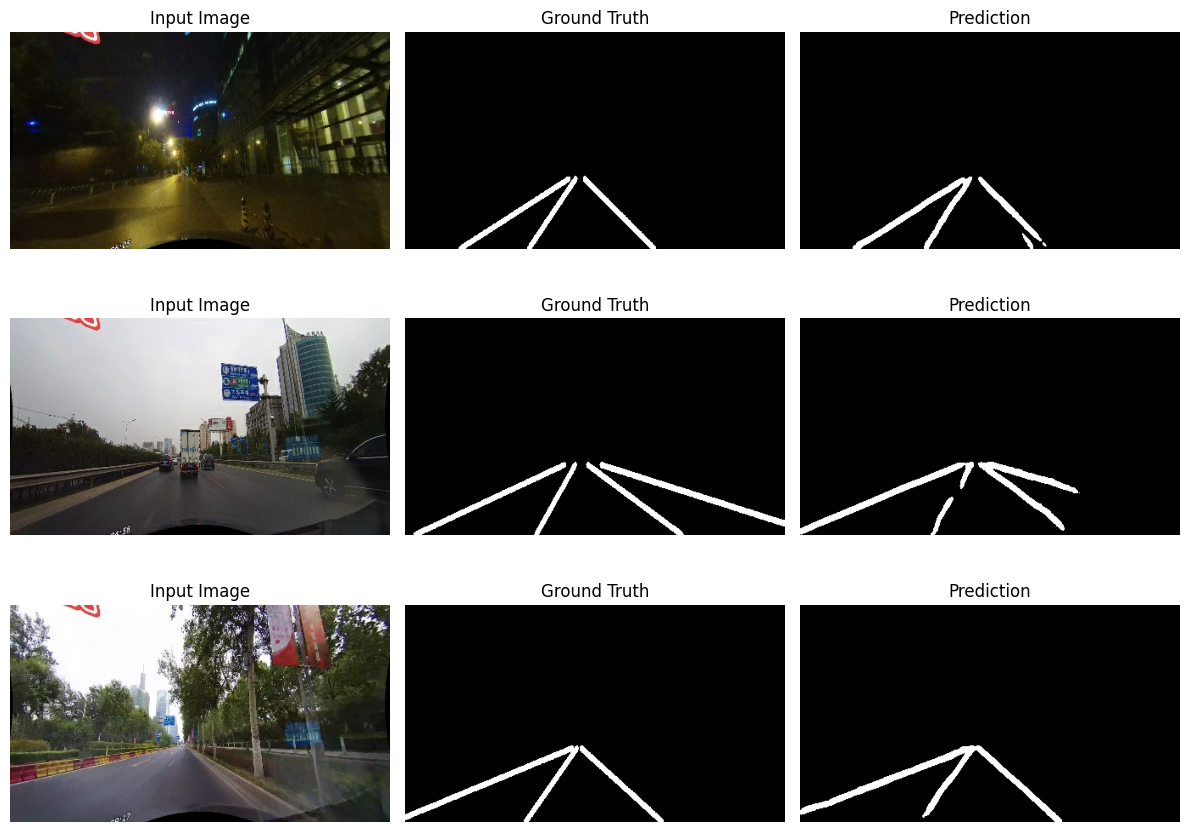

In [23]:
# Visualize Predictions on Validation Set
# Get one batch
for images, masks in val_ds.take(1):
    preds = model.predict(images)
    break

# Convert predictions to binary mask
pred_masks = (preds > 0.5).astype("uint8")

# Plot results
num_samples = 3
plt.figure(figsize=(12, 9))
for i in range(num_samples):
    plt.subplot(num_samples, 3, i*3 + 1)
    img_disp = images[i].numpy()
    if img_disp.dtype != np.uint8:
        img_disp = (img_disp * 255).clip(0, 255).astype("uint8")
    plt.imshow(img_disp)
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(num_samples, 3, i*3 + 2)
    plt.imshow(masks[i].numpy().squeeze(), cmap='gray')
    plt.title("Ground Truth")
    plt.axis("off")

    plt.subplot(num_samples, 3, i*3 + 3)
    plt.imshow(pred_masks[i].squeeze(), cmap='gray')
    plt.title("Prediction")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [18]:
# Prepare the Test Dataset
TEST_PATH = os.path.join(DATA_PATH, 'test')
test_ds = build_dataset(
    os.path.join(TEST_PATH, 'images'),
    os.path.join(TEST_PATH, 'masks'),
    augment=False,
    shuffle=False
)

In [20]:
# Predict on the Test Set
preds = model.predict(test_ds, verbose=1)

342/342 ━━━━━━━━━━━━━━━━━━━━ 38s 106ms/step


In [21]:
results = model.evaluate(test_ds)
print(f"Test Loss: {results[0]}")
print(f"Test Accuracy: {results[1]}")
print(f"Test Dice Coefficient: {results[2]}")

342/342 ━━━━━━━━━━━━━━━━━━━━ 35s 101ms/step - accuracy: 0.9844 - dice_coefficient: 0.6468 - loss: 0.4163
Test Loss: 0.41779959201812744
Test Accuracy: 0.9844426512718201
Test Dice Coefficient: 0.6451438069343567


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


2025-07-01 03:12:40.118259: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


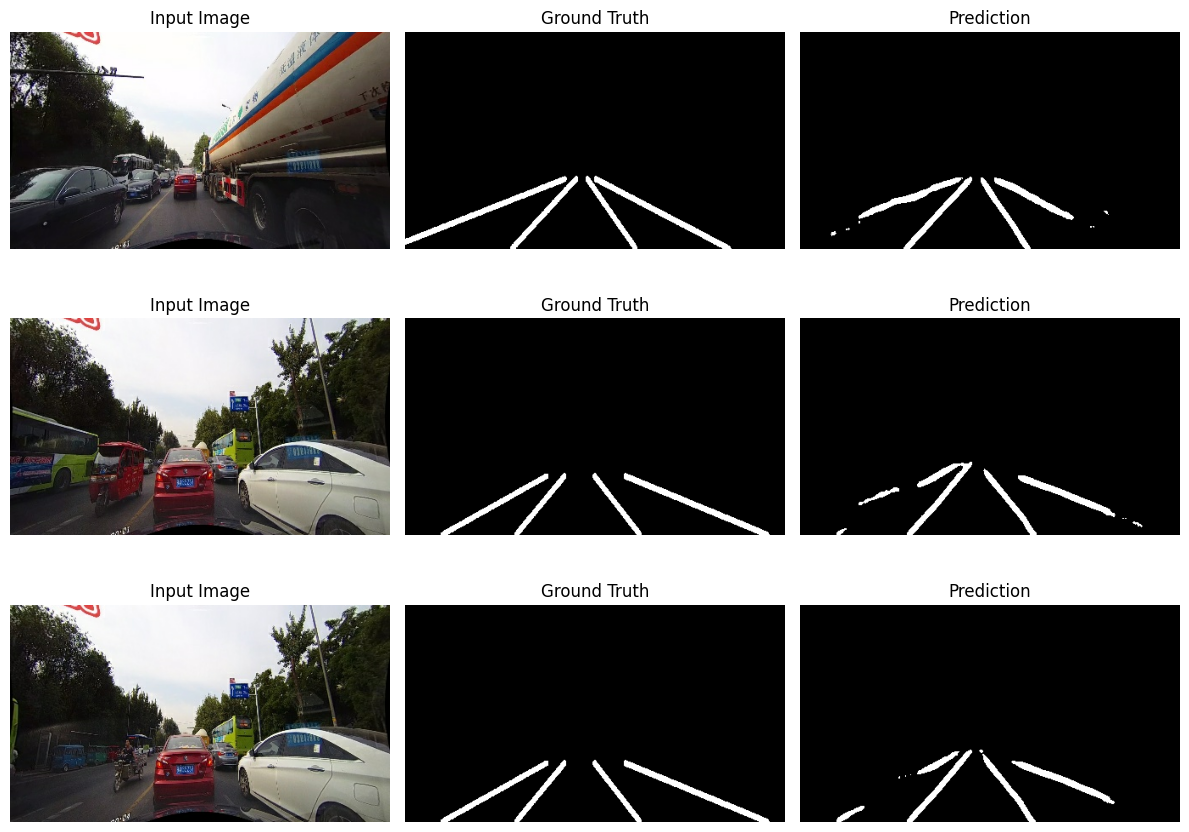

In [25]:
# Visualize Predictions on Test Set
# Get one batch
for images, masks in test_ds.take(1):
    preds = model.predict(images)
    break

# Convert predictions to binary mask
pred_masks = (preds > 0.5).astype("uint8")

# Plot results
num_samples = 3
plt.figure(figsize=(12, 9))
for i in range(num_samples):
    plt.subplot(num_samples, 3, i*3 + 1)
    img_disp = images[i].numpy()
    if img_disp.dtype != np.uint8:
        img_disp = (img_disp * 255).clip(0, 255).astype("uint8")
    plt.imshow(img_disp)
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(num_samples, 3, i*3 + 2)
    plt.imshow(masks[i].numpy().squeeze(), cmap='gray')
    plt.title("Ground Truth")
    plt.axis("off")

    plt.subplot(num_samples, 3, i*3 + 3)
    plt.imshow(pred_masks[i].squeeze(), cmap='gray')
    plt.title("Prediction")
    plt.axis("off")

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


2025-07-01 03:23:06.203924: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


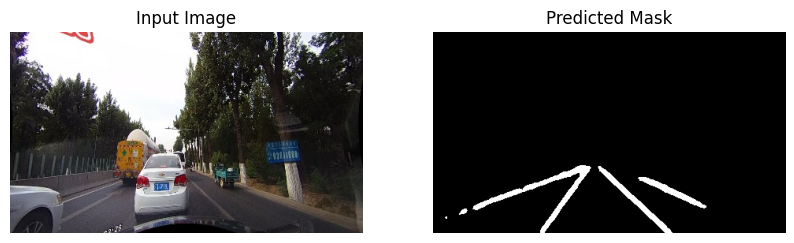

In [38]:
# Predict on New Data (If you want to use images outside the dataset)
def predict_and_visualize(image_path, model, img_size=(448, 256)):
    img = cv2.imread(image_path)
    img = cv2.resize(img, img_size)
    input_img = img.astype("float32") / 255.0  # Normalize if training had it
    input_img = tf.expand_dims(input_img, axis=0)

    pred = model.predict(input_img)[0]
    pred_mask = (pred > 0.5).astype("uint8") * 255

    # Plot
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(pred_mask.squeeze(), cmap="gray")
    plt.title("Predicted Mask")
    plt.axis("off")
    plt.show()

# Example
predict_and_visualize("/kaggle/input/road-lane-detection2/processed/test/images/06030822_0756.MP4_01890.jpg", model)

## Road Lane Detection Summary

**Model Architecture:** U-Net++  
**Input Resolution:** 256 × 448  
**Total Trainable Parameters:** 2,297,441  
**Optimizer:** Adam with Mixed Precision  
**Checkpointing:** Enabled with EarlyStopping & ReduceLROnPlateau  
**Resume Logic:** Included (model resumes from last best checkpoint)

### Evaluation Metrics on Test Set:
-  **Test Accuracy:** 0.9844  
-  **Dice Coefficient:** 0.6451  
-  **Test Loss:** 0.4178  

### Outputs and Artifacts:
- **Best Model Saved At:** `unetpp_best.keras`  
- **Evaluation + Visualization Included**

### Next Steps:
- Experiment with Attention U-Net or ResUNet variants  
- Improve Dice via data augmentation or better loss functions

